# Fraud Detection - Classification Model

The database that will be used to develop this challenge contains approximately 6.3 million transactions. The data contained in this database is simulated and comprises 30 days. These transactions can be of different types and were executed via mobile devices. The features contained in this database are:

- step - Step: represents the total hours elapsed since the beginning of the simulation. This feature will vary between 1 and 744 (30 days);

- type - Type: transaction type (deposit, withdrawal, debit, payment, and transfer);

- amount - Amount: total that was transacted;

- nameOrig - CustomerOrigin: the customer who initiated the transaction

- oldbalanceOrg - OriginalBalanceOrigin: balance of the original account before the transaction;

- newbalanceOrig - BalanceOrigin: balance of the original account after the transaction;

- nameDest - ClienteDestino: target client of the transaction;

- oldbalanceDest -DestinationInitialBalance: balance of the destination account before the transaction;

- newbalanceDest - SaldoFinalDestino: balance of the destination account after the transaction;

- isFraud - ÉFraud: flag that defines whether the transaction is fraudulent or not. In this simulation, the purpose of the fraud is to take over the user's account, empty it by transferring it to another account, and then withdraw the money.

- isFlaggedFraud - FlaggedAsFraud: automatically flagged by the bank as fraud for trying to transfer more than 200,000 in a single transaction.

It is good to run this notebook using 
jupyter notebook --NotebookApp.iopub_data_rate_limit=1.0e10 
in Anaconda's prompt due to high memory usage.

In [1]:
%reload_ext nb_black

!pip install matplotlib==3.4.0
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

%matplotlib inline

import statsmodels.api as sm

import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
)
from sklearn.multiclass import OneVsRestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler

<IPython.core.display.Javascript object>

## Dataset General Info

In [2]:
data = pd.read_csv("fraud_detection_dataset.csv")

<IPython.core.display.Javascript object>

In [3]:
pd.set_option("display.max_columns", None)
data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


<IPython.core.display.Javascript object>

In [4]:
data.tail()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.0,C776919290,0.00,339682.13,1,0
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.0,C1881841831,0.00,0.00,1,0
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.0,C1365125890,68488.84,6379898.11,1,0
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.0,C2080388513,0.00,0.00,1,0
6362619,743,CASH_OUT,850002.52,C1280323807,850002.52,0.0,C873221189,6510099.11,7360101.63,1,0


<IPython.core.display.Javascript object>

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


<IPython.core.display.Javascript object>

In [6]:
data.type = data.type.astype("category")
data.nameOrig = data.nameOrig.astype("category")
data.nameDest = data.nameDest.astype("category")

<IPython.core.display.Javascript object>

In [7]:
data.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


<IPython.core.display.Javascript object>

In [8]:
data["nameDest"].unique()

['M1979787155', 'M2044282225', 'C553264065', 'C38997010', 'M1230701703', ..., 'C1812552860', 'C1470998563', 'C1850423904', 'C1881841831', 'C2080388513']
Length: 2722362
Categories (2722362, object): ['C1000004082', 'C1000004940', 'C1000013769', 'C100001587', ..., 'M99999900', 'M999999089', 'M999999543', 'M999999784']

<IPython.core.display.Javascript object>

In [9]:
# Quantity of detected frauds
data["isFraud"].value_counts()

0    6354407
1       8213
Name: isFraud, dtype: int64

<IPython.core.display.Javascript object>

In [10]:
# Quantity of flagged frauds
data["isFlaggedFraud"].value_counts()

0    6362604
1         16
Name: isFlaggedFraud, dtype: int64

<IPython.core.display.Javascript object>

In [11]:
# No null cells were found
data.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

<IPython.core.display.Javascript object>

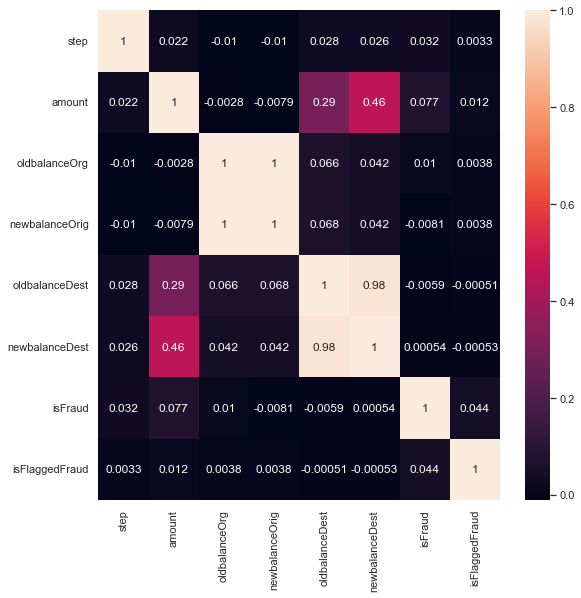

<IPython.core.display.Javascript object>

In [12]:
sns.set(rc={"figure.figsize": (9, 9)})
_ = sns.heatmap(data.corr(), annot=True)

The top3 variables with higher correlation with variable "isFraud" are: "amount", "isFlaggedFraud" and "step".

In [13]:
# Verifying the amount of flagged frauds that are really fraud.
isFlaggedFraud_list = data["isFlaggedFraud"].tolist()
isFraud_list = data["isFraud"].tolist()
count_a = 0
count_b = 0

for i in isFlaggedFraud_list:
    if i == 1 and isFraud_list[count_a] == 1:
        count_b += 1
    count_a += 1
print("Quantity of Flagged Frauds that are Fraud:", count_b)

Quantity of Flagged Frauds that are Fraud: 16


<IPython.core.display.Javascript object>

In [14]:
data["isFlaggedFraud"].value_counts()

0    6362604
1         16
Name: isFlaggedFraud, dtype: int64

<IPython.core.display.Javascript object>

In [15]:
# Verifying the quantity of transactions that should be flagged as fraud.
amount_list = data["amount"].tolist()
count_a = 0

for i in amount_list:
    if i >= 200000:
        count_a += 1
print(
    "The quantity of transactions that should be considered as Flagged Fraud is:",
    count_a,
)

The quantity of transactions that should be considered as Flagged Fraud is: 1673570


<IPython.core.display.Javascript object>

## Split Dataset in train and test

In [16]:
X = data[
    [
        "step",
        "type",
        "amount",
        "nameOrig",
        "oldbalanceOrg",
        "newbalanceOrig",
        "nameDest",
        "oldbalanceDest",
        "newbalanceDest",
        "isFlaggedFraud",
    ]
]
Y = data[["isFraud"]]

X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.25, random_state=42, stratify=Y
)

<IPython.core.display.Javascript object>

[Text(0.5, 1.0, 'COUNTPLOT OF VARIABLE TARGET')]

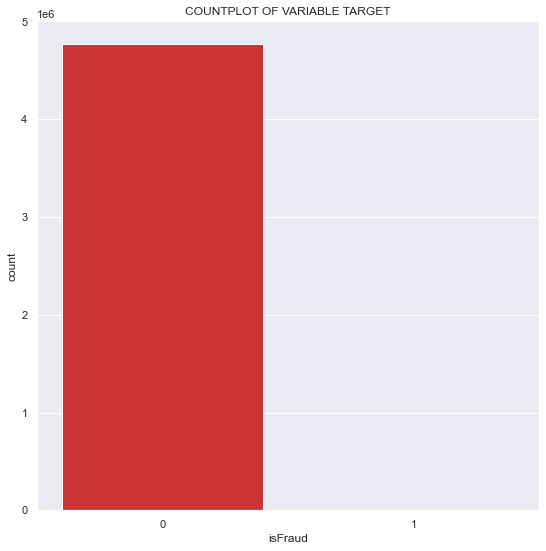

<IPython.core.display.Javascript object>

In [17]:
# Verifying isFraud proportion. Variable is highly unbalanced.

sns.countplot(x="isFraud", data=y_train, palette="Set1").set(
    title="COUNTPLOT OF VARIABLE TARGET"
)

## Feature Engineering

In [18]:
# Function to describe how many times the recipient appeared during the selected period.


def account_freq(data, column):
    freq = {}
    freq1 = []
    new_list = data[column].tolist()
    for item in new_list:
        if item in freq:
            freq[item] += 1
        else:
            freq[item] = 1
    for i in new_list:
        if i in freq:
            freq1.append(freq[i])
    return freq1


X_train["nameDest_freq"] = account_freq(X_train, "nameDest")
X_train.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFlaggedFraud,nameDest_freq
2947509,230,PAYMENT,25106.21,C210872802,50850.00,25743.79,M1247923037,0.00,0.00,0,1
983137,44,CASH_IN,226426.20,C1220670739,3815346.61,4041772.81,C377231511,1206782.67,980356.47,0,22
2596796,208,PAYMENT,662.24,C987540411,144407.43,143745.20,M1894711811,0.00,0.00,0,1
3122557,236,CASH_OUT,128838.38,C2130004271,16173.00,0.00,C497476412,0.00,128838.38,0,2
5998010,426,TRANSFER,198986.72,C82269278,0.00,0.00,C1469084853,789447.96,988434.68,0,7


<IPython.core.display.Javascript object>

In [19]:
X_test["nameDest_freq"] = account_freq(X_test, "nameDest")
X_test.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFlaggedFraud,nameDest_freq
3752514,279,CASH_OUT,285258.69,C1035798537,5069.00,0.00,C10875961,110028.82,395287.51,0,2
1513169,153,PAYMENT,8390.18,C475011650,0.00,0.00,M375874820,0.00,0.00,0,1
3963907,297,CASH_OUT,246084.63,C1114586565,215279.52,0.00,C1454593196,2057450.59,2303535.22,0,3
843691,41,CASH_OUT,445868.10,C876318892,24316.00,0.00,C2140124220,0.00,445868.10,0,2
3437791,256,PAYMENT,14899.69,C1244849504,100698.58,85798.88,M2069540574,0.00,0.00,0,1


<IPython.core.display.Javascript object>

In [20]:
# Function to describe if the recipient was already set as fraud in another transaction.


def account_is_fraud(data1, data2, column1, column2):
    freq = {}
    freq1 = []
    nameDest_list = data1[column1].tolist()
    isFraud_list = data2[column2].tolist()
    count = 0
    for item in isFraud_list:
        if item == 1:
            freq[nameDest_list[count]] = 1
        count += 1
    for i in nameDest_list:
        if i in freq:
            freq1.append(1)
        else:
            freq1.append(0)
    return freq1


X_train["accountIsFraud"] = account_is_fraud(X_train, y_train, "nameDest", "isFraud")
X_train.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFlaggedFraud,nameDest_freq,accountIsFraud
2947509,230,PAYMENT,25106.21,C210872802,50850.00,25743.79,M1247923037,0.00,0.00,0,1,0
983137,44,CASH_IN,226426.20,C1220670739,3815346.61,4041772.81,C377231511,1206782.67,980356.47,0,22,0
2596796,208,PAYMENT,662.24,C987540411,144407.43,143745.20,M1894711811,0.00,0.00,0,1,0
3122557,236,CASH_OUT,128838.38,C2130004271,16173.00,0.00,C497476412,0.00,128838.38,0,2,0
5998010,426,TRANSFER,198986.72,C82269278,0.00,0.00,C1469084853,789447.96,988434.68,0,7,0


<IPython.core.display.Javascript object>

In [21]:
X_test["accountIsFraud"] = account_is_fraud(X_test, y_test, "nameDest", "isFraud")
X_test.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFlaggedFraud,nameDest_freq,accountIsFraud
3752514,279,CASH_OUT,285258.69,C1035798537,5069.00,0.00,C10875961,110028.82,395287.51,0,2,0
1513169,153,PAYMENT,8390.18,C475011650,0.00,0.00,M375874820,0.00,0.00,0,1,0
3963907,297,CASH_OUT,246084.63,C1114586565,215279.52,0.00,C1454593196,2057450.59,2303535.22,0,3,0
843691,41,CASH_OUT,445868.10,C876318892,24316.00,0.00,C2140124220,0.00,445868.10,0,2,0
3437791,256,PAYMENT,14899.69,C1244849504,100698.58,85798.88,M2069540574,0.00,0.00,0,1,0


<IPython.core.display.Javascript object>

## Re-Scaling the Data

In [22]:
scaler = StandardScaler()
X_train[
    ["amount", "oldbalanceOrg", "newbalanceOrig", "oldbalanceDest", "newbalanceDest",]
] = scaler.fit_transform(
    X_train[
        [
            "amount",
            "oldbalanceOrg",
            "newbalanceOrig",
            "oldbalanceDest",
            "newbalanceDest",
        ]
    ]
)
X_test[
    ["amount", "oldbalanceOrg", "newbalanceOrig", "oldbalanceDest", "newbalanceDest",]
] = scaler.fit_transform(
    X_test[
        [
            "amount",
            "oldbalanceOrg",
            "newbalanceOrig",
            "oldbalanceDest",
            "newbalanceDest",
        ]
    ]
)

<IPython.core.display.Javascript object>

In [23]:
X_train.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFlaggedFraud,nameDest_freq,accountIsFraud
count,4.771965e+06,4.771965e+06,4.771965e+06,4.771965e+06,4.771965e+06,4.771965e+06,4.771965e+06,4.771965e+06,4.771965e+06
mean,2.434026e+02,-4.119203e-17,-7.696846e-15,-3.435934e-15,-6.952186e-15,-6.085696e-15,3.352916e-06,8.644470e+00,8.089540e-03
std,1.423319e+02,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.831094e-03,9.396455e+00,8.957734e-02
min,1.000000e+00,-2.992193e-01,-2.888002e-01,-2.925170e-01,-3.243188e-01,-3.339939e-01,0.000000e+00,1.000000e+00,0.000000e+00
25%,1.560000e+02,-2.769357e-01,-2.888002e-01,-2.925170e-01,-3.243188e-01,-3.339939e-01,0.000000e+00,1.000000e+00,0.000000e+00
50%,2.390000e+02,-1.747272e-01,-2.838746e-01,-2.925170e-01,-2.851908e-01,-2.753628e-01,0.000000e+00,5.000000e+00,0.000000e+00
75%,3.350000e+02,4.790807e-02,-2.516192e-01,-2.431779e-01,-4.632481e-02,-3.058528e-02,0.000000e+00,1.300000e+01,0.000000e+00
max,7.430000e+02,1.535130e+02,2.034190e+01,1.666546e+01,1.046073e+02,9.680458e+01,1.000000e+00,8.700000e+01,1.000000e+00


<IPython.core.display.Javascript object>

## One Hot Encoder for the variable "type".

In [24]:
# LogisticRegression function does not run strings.

import category_encoders as ce

encoder = ce.OneHotEncoder(use_cat_names=True)
df_encoded_train = encoder.fit_transform(X_train["type"])
df_encoded_test = encoder.fit_transform(X_test["type"])
df_encoded_train.head()

,type_PAYMENT,type_CASH_IN,type_CASH_OUT,type_TRANSFER,type_DEBIT
2947509,1,0,0,0,0
983137,0,1,0,0,0
2596796,1,0,0,0,0
3122557,0,0,1,0,0
5998010,0,0,0,1,0


<IPython.core.display.Javascript object>

In [25]:
X_train["type_CASH_IN"] = df_encoded_train["type_CASH_IN"].copy(deep=True)
X_train["type_PAYMENT"] = df_encoded_train["type_PAYMENT"].copy(deep=True)
X_train["type_CASH_OUT"] = df_encoded_train["type_CASH_OUT"].copy(deep=True)
X_train["type_TRANSFER"] = df_encoded_train["type_TRANSFER"].copy(deep=True)
X_train["type_DEBIT"] = df_encoded_train["type_DEBIT"].copy(deep=True)

X_test["type_CASH_IN"] = df_encoded_test["type_CASH_IN"].copy(deep=True)
X_test["type_PAYMENT"] = df_encoded_test["type_PAYMENT"].copy(deep=True)
X_test["type_CASH_OUT"] = df_encoded_test["type_CASH_OUT"].copy(deep=True)
X_test["type_TRANSFER"] = df_encoded_test["type_TRANSFER"].copy(deep=True)
X_test["type_DEBIT"] = df_encoded_test["type_DEBIT"].copy(deep=True)

<IPython.core.display.Javascript object>

In [26]:
X_train.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFlaggedFraud,nameDest_freq,accountIsFraud,type_CASH_IN,type_PAYMENT,type_CASH_OUT,type_TRANSFER,type_DEBIT
2947509,230,PAYMENT,-0.257447,C210872802,-0.271194,-0.283713,M1247923037,-0.324319,-0.333994,0,1,0,0,1,0,0,0
983137,44,CASH_IN,0.077512,C1220670739,1.032224,1.089761,C377231511,0.031367,-0.066627,0,22,0,1,0,0,0,0
2596796,208,PAYMENT,-0.298117,C987540411,-0.238801,-0.243356,M1894711811,-0.324319,-0.333994,0,1,0,0,1,0,0,0
3122557,236,CASH_OUT,-0.084856,C2130004271,-0.283200,-0.292517,C497476412,-0.324319,-0.298857,0,2,0,0,0,1,0,0
5998010,426,TRANSFER,0.031858,C82269278,-0.288800,-0.292517,C1469084853,-0.091638,-0.064424,0,7,0,0,0,0,1,0


<IPython.core.display.Javascript object>

#### Selecting variables for the model

In [27]:
# isFlaggedFraud will not be considered due to missing right input for values above 200,000.
# Among the numerical variables, it is interesting to keep the variables that are most correlated to the variable target, and less correlated among themselves.
# For categorical variables, it is necessary to keep them encoded.

selected_X_train = X_train.drop(
    ["type", "nameOrig", "nameDest", "isFlaggedFraud",], axis=1,
)

selected_X_test = X_test.drop(
    ["type", "nameOrig", "nameDest", "isFlaggedFraud",], axis=1,
)

<IPython.core.display.Javascript object>

In [28]:
selected_X_train.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,nameDest_freq,accountIsFraud,type_CASH_IN,type_PAYMENT,type_CASH_OUT,type_TRANSFER,type_DEBIT
2947509,230,-0.257447,-0.271194,-0.283713,-0.324319,-0.333994,1,0,0,1,0,0,0
983137,44,0.077512,1.032224,1.089761,0.031367,-0.066627,22,0,1,0,0,0,0
2596796,208,-0.298117,-0.238801,-0.243356,-0.324319,-0.333994,1,0,0,1,0,0,0
3122557,236,-0.084856,-0.283200,-0.292517,-0.324319,-0.298857,2,0,0,0,1,0,0
5998010,426,0.031858,-0.288800,-0.292517,-0.091638,-0.064424,7,0,0,0,0,1,0


<IPython.core.display.Javascript object>

## Logistic Regression: Trial #1 - training the model

In [29]:
model = LogisticRegression(max_iter=100, multi_class="ovr", solver="saga", penalty="l1")

<IPython.core.display.Javascript object>

In [30]:
model.fit(selected_X_train, y_train)

C:\Users\User\anaconda3\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogisticRegression(multi_class='ovr', penalty='l1', solver='saga')

<IPython.core.display.Javascript object>

## Metrics

In [31]:
y_pred = model.predict(selected_X_test)

<IPython.core.display.Javascript object>

In [32]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1588602
           1       0.80      0.09      0.15      2053

    accuracy                           1.00   1590655
   macro avg       0.90      0.54      0.58   1590655
weighted avg       1.00      1.00      1.00   1590655



<IPython.core.display.Javascript object>

#### Trial #1 with max_iter=100, multi_class="ovr", solver="saga" and penalty="l1" did not perform so well.
#### I will try as logisticregression().

### Auxiliar Functions

In [33]:
### Auxiliar Functions


def plot_proportion(y_true):
    plt.style.use("ggplot")
    aux = (
        pd.Series(y_true)
        .value_counts()
        .reset_index()
        .rename({"index": "class", 0: "samples"}, axis=1)
    )
    fig, ax = plt.subplots(figsize=(12, 5))
    ax = sns.barplot(data=aux, x="class", y="samples", ax=ax)
    ax.bar_label(ax.containers[0])


def evaluate(y_true, y_pred_proba, threshold=0.5):
    y_pred = (y_pred_proba >= threshold).astype(int)
    results = dict()
    results["accuracy"] = accuracy_score(y_true, y_pred)
    results["precision"] = precision_score(y_true, y_pred)
    results["recall"] = recall_score(y_true, y_pred)
    results["f1"] = f1_score(y_true, y_pred)
    return results


def predict(cls, X_train, y_train, X_test, y_test, name):
    cls.fit(X_train, y_train)
    y_pred_proba = cls.predict_proba(X_test)[:, 1]
    metrics = evaluate(y_test, y_pred_proba)
    metrics["name"] = name
    return metrics, y_pred_proba


def append(df, row):
    return pd.concat([df, pd.DataFrame([row])]).sort_values("recall", ascending=False)

<IPython.core.display.Javascript object>

In [34]:
# I will call the first trial "Benchmark"
lr = LogisticRegression()
bench_metric, y_pred_proba = predict(
    lr, selected_X_train, y_train, selected_X_test, y_test, "benchmark"
)
bench_metric

C:\Users\User\anaconda3\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


{'accuracy': 0.9994832317504424,
 'precision': 0.9659348978046934,
 'recall': 0.6215294690696541,
 'f1': 0.7563722584469472,
 'name': 'benchmark'}

<IPython.core.display.Javascript object>

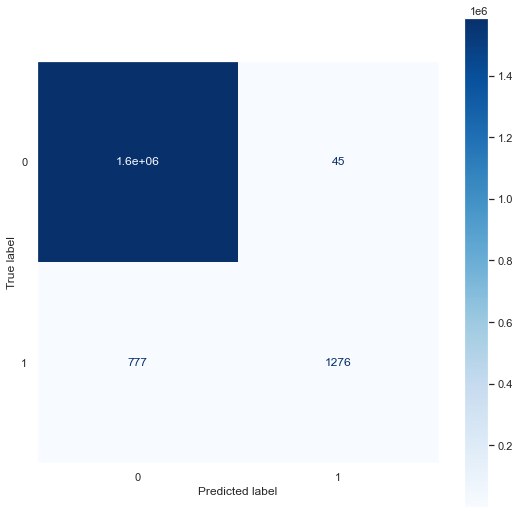

<IPython.core.display.Javascript object>

In [35]:
ConfusionMatrixDisplay.from_predictions(
    y_test, (y_pred_proba >= 0.5).astype(int), cmap="Blues"
)  # Threshold = 0.5
plt.grid(False)

In [36]:
evaluations = pd.DataFrame()
evaluations = append(evaluations, bench_metric)
evaluations

,accuracy,precision,recall,f1,name
0,0.999483,0.965935,0.621529,0.756372,benchmark


<IPython.core.display.Javascript object>

## Finding the best Threshold

In [37]:
# The function below will generate as result the threshold with the best score for the recall
best_recall = 0
best_threshold = 0
for i in range(1, 10):
    recall = evaluate(y_test, y_pred_proba, threshold=i / 10)["recall"]
    if recall >= best_recall:
        best_threshold = i / 10
        best_recall = recall

threshold_metric = evaluate(y_test, y_pred_proba, threshold=best_threshold)
threshold_metric["name"] = f"threshold_{best_threshold}"
evaluations = append(evaluations, threshold_metric)
evaluations

,accuracy,precision,recall,f1,name
0,0.999271,0.659750,0.898198,0.760726,threshold_0.1
0,0.999483,0.965935,0.621529,0.756372,benchmark


<IPython.core.display.Javascript object>

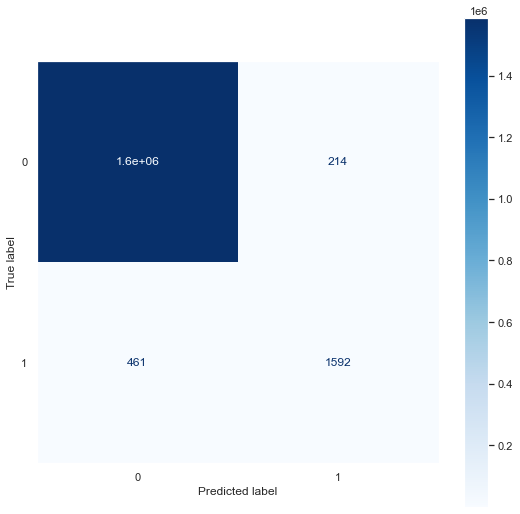

<IPython.core.display.Javascript object>

In [38]:
ConfusionMatrixDisplay.from_predictions(
    y_test, (y_pred_proba >= 0.3).astype(int), cmap="Blues"
)
plt.grid(False)

## Class Weight

Weights associated with classes in the form {class_label: weight}. If not given, all classes are supposed to have weight one.

The “balanced” mode uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data as n_samples / (n_classes * np.bincount(y)).

In [40]:
lr = LogisticRegression(class_weight="balanced")
balanced_metrics, y_pred_proba = predict(
    lr, selected_X_train, y_train, selected_X_test, y_test, "class_weight_balanced"
)
evaluations = append(evaluations, balanced_metrics)
evaluations

C:\Users\User\anaconda3\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,accuracy,precision,recall,f1,name
0,0.998484,0.459798,1.000000,0.629948,class_weight_balanced
0,0.999271,0.659750,0.898198,0.760726,threshold_0.1
0,0.999483,0.965935,0.621529,0.756372,benchmark


<IPython.core.display.Javascript object>

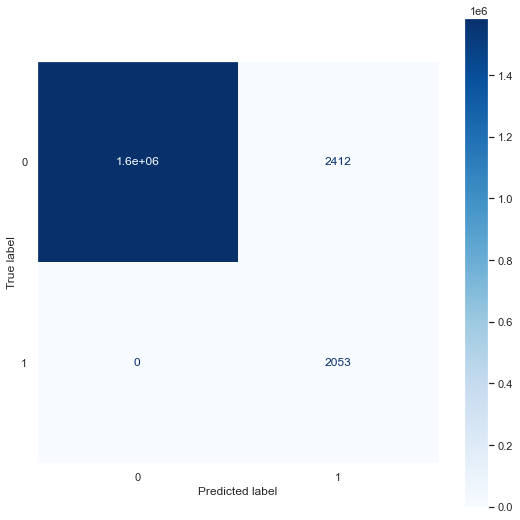

<IPython.core.display.Javascript object>

In [41]:
ConfusionMatrixDisplay.from_predictions(
    y_test, (y_pred_proba >= 0.5).astype(int), cmap="Blues"
)
plt.grid(False)

This result perfectly identified all the frauds in the test dataset, and it was wrong about 0.15% of the normal transactions.

Even though, I will keep testing to check other possibilities that may enhance precision and accurancy.

In [43]:
lr = LogisticRegression(class_weight={0: 1, 1: 10})
balanced_metrics, y_pred_proba = predict(
    lr, selected_X_train, y_train, selected_X_test, y_test, "class_weight_arbitrary"
)
evaluations = append(evaluations, balanced_metrics)
evaluations

C:\Users\User\anaconda3\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,accuracy,precision,recall,f1,name
0,0.998484,0.459798,1.000000,0.629948,class_weight_balanced
0,0.999237,0.641414,0.927910,0.758511,class_weight_arbitrary
0,0.999271,0.659750,0.898198,0.760726,threshold_0.1
0,0.999483,0.965935,0.621529,0.756372,benchmark


<IPython.core.display.Javascript object>

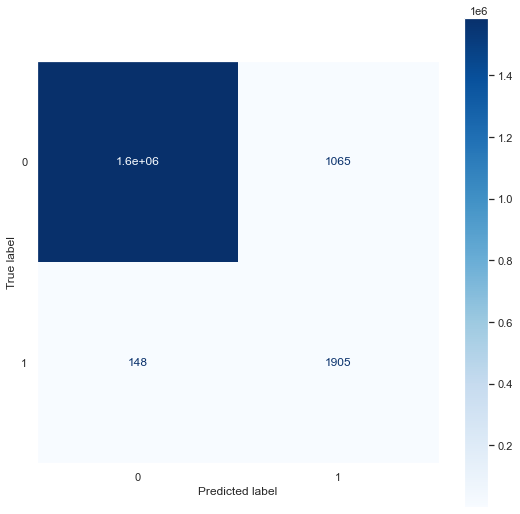

<IPython.core.display.Javascript object>

In [44]:
ConfusionMatrixDisplay.from_predictions(
    y_test, (y_pred_proba >= 0.5).astype(int), cmap="Blues"
)
plt.grid(False)

## Random Under Sampling

The random under sampling is a technique which randomly removes samples from the majotiry class.

In [50]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(sampling_strategy=0.1, random_state=42) #Used a 10% strategy of sampling for the positive class.
X_res, y_res = rus.fit_resample(selected_X_train, y_train)

<IPython.core.display.Javascript object>

[Text(0.5, 1.0, 'COUNTPLOT OF VARIABLE TARGET FOR RANDOM UNDER SAMPLING')]

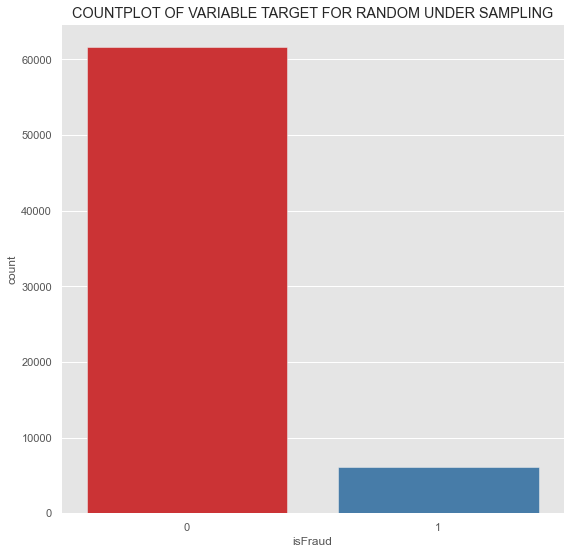

<IPython.core.display.Javascript object>

In [51]:
sns.countplot(x="isFraud", data=y_res, palette="Set1").set(
    title="COUNTPLOT OF VARIABLE TARGET FOR RANDOM UNDER SAMPLING"
)

In [53]:
lr = LogisticRegression()
rus_metrics, y_pred_proba = predict(
    lr, X_res, y_res, selected_X_test, y_test, "RandomUnderSampling"
)
evaluations = append(evaluations, rus_metrics)
evaluations

C:\Users\User\anaconda3\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,accuracy,precision,recall,f1,name
0,0.998484,0.459798,1.000000,0.629948,class_weight_balanced
0,0.998490,0.460831,1.000000,0.630916,RandomUnderSampling
0,0.999237,0.641414,0.927910,0.758511,class_weight_arbitrary
0,0.999271,0.659750,0.898198,0.760726,threshold_0.1
0,0.999483,0.965935,0.621529,0.756372,benchmark


<IPython.core.display.Javascript object>

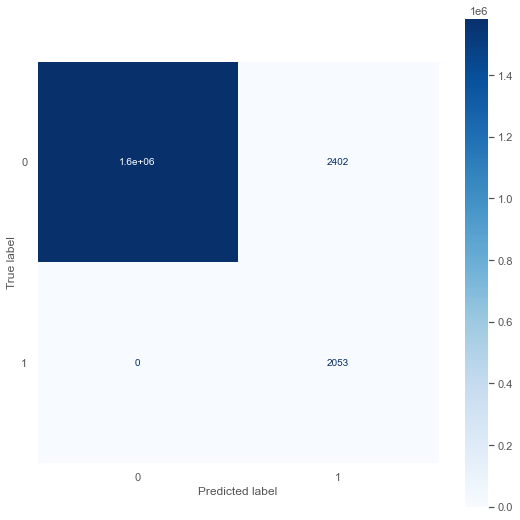

<IPython.core.display.Javascript object>

In [54]:
ConfusionMatrixDisplay.from_predictions(
    y_test, (y_pred_proba >= 0.5).astype(int), cmap="Blues"
)
plt.grid(False)

## Under Sampling - Edited Nearest Neighbours

KNN algorithm removes samples that are on the decision border.
By default the number of neighbors is 3, and it only removes if all the 3 neighbors are from the other class.

In [56]:
from imblearn.under_sampling import EditedNearestNeighbours

enn = EditedNearestNeighbours(kind_sel="all", n_neighbors=3)
X_res, y_res = enn.fit_resample(selected_X_train, y_train)

<IPython.core.display.Javascript object>

[Text(0.5, 1.0, 'COUNTPLOT OF VARIABLE TARGET FOR EDDITED NEAREST NEIGHBOURS UNDER SAMPLING')]

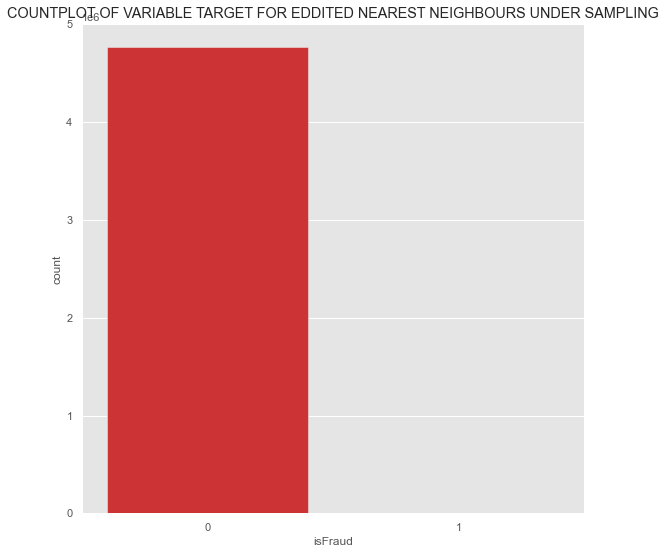

<IPython.core.display.Javascript object>

In [57]:
sns.countplot(x="isFraud", data=y_res, palette="Set1").set(
    title="COUNTPLOT OF VARIABLE TARGET FOR EDDITED NEAREST NEIGHBOURS UNDER SAMPLING"
)

Or it is possible to remove elements if the majority of the neighbors are from the minority class (it leaves more elements on the border).

In [59]:
enn = EditedNearestNeighbours(kind_sel="mode")
X_res, y_res = enn.fit_resample(selected_X_train, y_train)

<IPython.core.display.Javascript object>

[Text(0.5, 1.0, 'COUNTPLOT OF VARIABLE TARGET FOR EDDITED NEAREST NEIGHBOURS UNDER SAMPLING')]

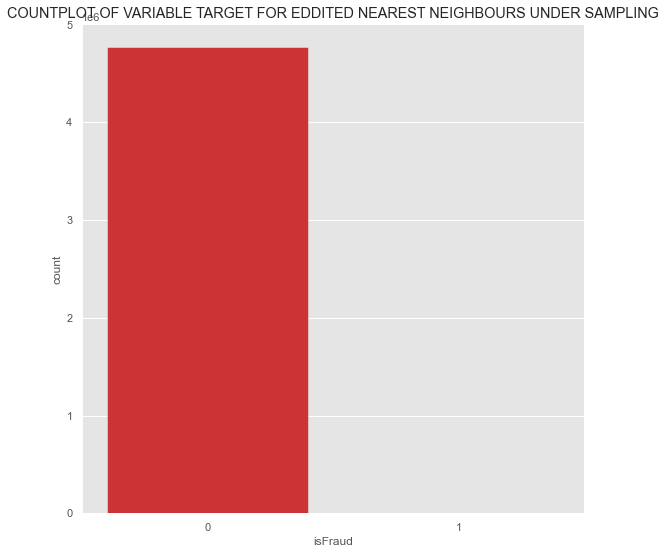

<IPython.core.display.Javascript object>

In [60]:
sns.countplot(x="isFraud", data=y_res, palette="Set1").set(
    title="COUNTPLOT OF VARIABLE TARGET FOR EDDITED NEAREST NEIGHBOURS UNDER SAMPLING"
)

It is allowed to select the number of neighbors too.

In [61]:
enn = EditedNearestNeighbours(kind_sel="all", n_neighbors=5)
X_res, y_res = enn.fit_resample(selected_X_train, y_train)

<IPython.core.display.Javascript object>

[Text(0.5, 1.0, 'COUNTPLOT OF VARIABLE TARGET FOR EDDITED NEAREST NEIGHBOURS UNDER SAMPLING')]

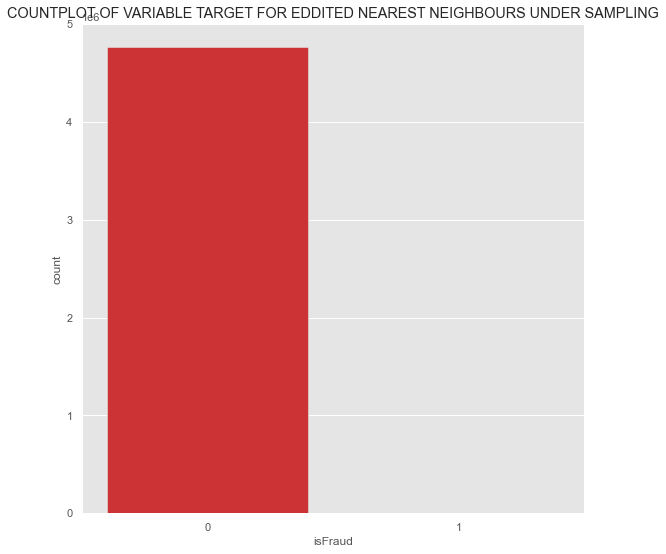

<IPython.core.display.Javascript object>

In [62]:
sns.countplot(x="isFraud", data=y_res, palette="Set1").set(
    title="COUNTPLOT OF VARIABLE TARGET FOR EDDITED NEAREST NEIGHBOURS UNDER SAMPLING"
)

In [63]:
lr = LogisticRegression()
rus_metrics, y_pred_proba = predict(
    lr, X_res, y_res, selected_X_test, y_test, "EditedNearestNeighbours"
)
evaluations = append(evaluations, rus_metrics)
evaluations

C:\Users\User\anaconda3\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,accuracy,precision,recall,f1,name
0,0.998484,0.459798,1.000000,0.629948,class_weight_balanced
0,0.998490,0.460831,1.000000,0.630916,RandomUnderSampling
0,0.999237,0.641414,0.927910,0.758511,class_weight_arbitrary
0,0.999271,0.659750,0.898198,0.760726,threshold_0.1
0,0.999573,0.957972,0.699464,0.808559,EditedNearestNeighbours
0,0.999483,0.965935,0.621529,0.756372,benchmark


<IPython.core.display.Javascript object>

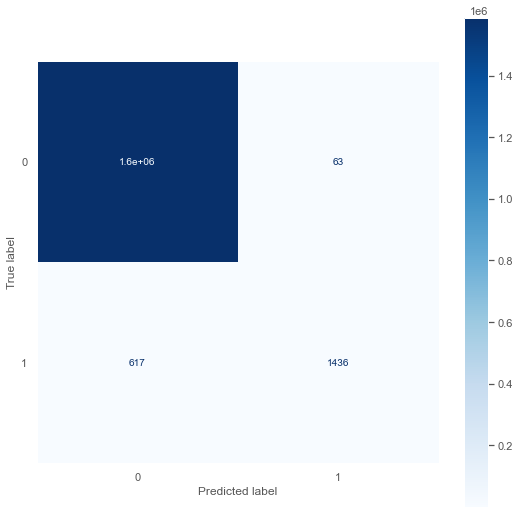

<IPython.core.display.Javascript object>

In [64]:
ConfusionMatrixDisplay.from_predictions(
    y_test, (y_pred_proba >= 0.5).astype(int), cmap="Blues"
)
plt.grid(False)

## Random Over Sampling

Object to over-sample the minority class(es) by picking samples at random with replacement. By default, it raises the number of elements from the minority class to the same number of elements of the majority class. 

In [66]:
ros = RandomOverSampler(random_state=42, sampling_strategy=0.05)
X_res, y_res = ros.fit_resample(selected_X_train, y_train)

<IPython.core.display.Javascript object>

[Text(0.5, 1.0, 'COUNTPLOT OF VARIABLE TARGET FOR RANDOM OVER SAMPLING')]

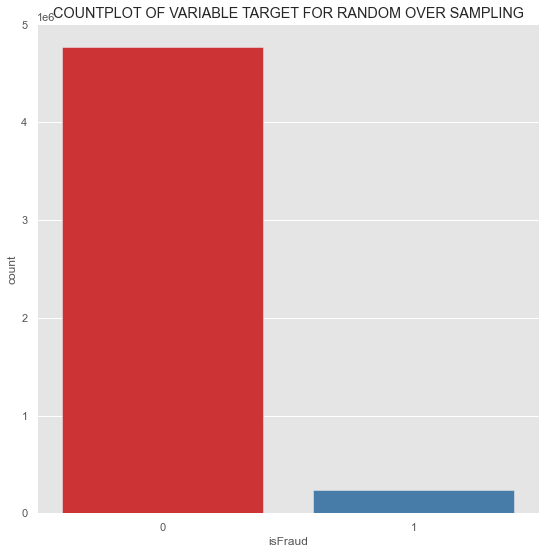

<IPython.core.display.Javascript object>

In [67]:
sns.countplot(x="isFraud", data=y_res, palette="Set1").set(
    title="COUNTPLOT OF VARIABLE TARGET FOR RANDOM OVER SAMPLING"
)

In [68]:
lr = LogisticRegression()
ros_metrics, y_pred_proba = predict(
    lr, X_res, y_res, selected_X_test, y_test, "RandomOverSampling"
)
evaluations = append(evaluations, ros_metrics)
evaluations

C:\Users\User\anaconda3\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,accuracy,precision,recall,f1,name
0,0.998484,0.459798,1.000000,0.629948,class_weight_balanced
0,0.998490,0.460831,1.000000,0.630916,RandomUnderSampling
0,0.998584,0.476777,1.000000,0.645699,RandomOverSampling
0,0.999237,0.641414,0.927910,0.758511,class_weight_arbitrary
0,0.999271,0.659750,0.898198,0.760726,threshold_0.1
0,0.999573,0.957972,0.699464,0.808559,EditedNearestNeighbours
0,0.999483,0.965935,0.621529,0.756372,benchmark


<IPython.core.display.Javascript object>

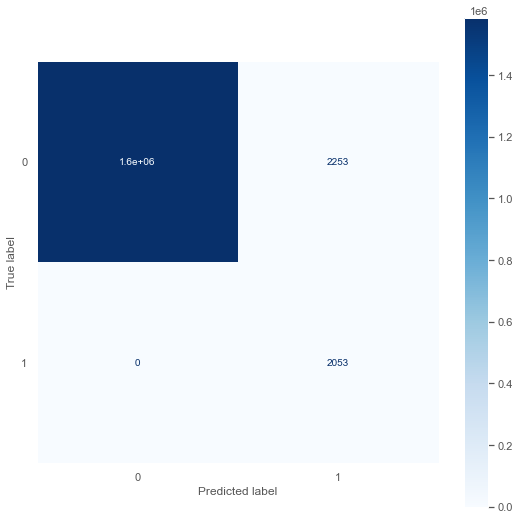

<IPython.core.display.Javascript object>

In [69]:
ConfusionMatrixDisplay.from_predictions(
    y_test, (y_pred_proba >= 0.5).astype(int), cmap="Blues"
)
plt.grid(False)

## SMOTE

SMOTE creates synthetic data from the minority class, throguh linear interpolation between the neighbours within the class.

Note: SMOTE can create data that it may be impossible to occur in the real world.
By default, it raises the number of elements from the minority class to the same number of elements from majority's.

In [71]:
smote = SMOTE(random_state=42, sampling_strategy=0.05)
X_res, y_res = smote.fit_resample(selected_X_train, y_train)

<IPython.core.display.Javascript object>

[Text(0.5, 1.0, 'COUNTPLOT OF VARIABLE TARGET FOR SMOTE')]

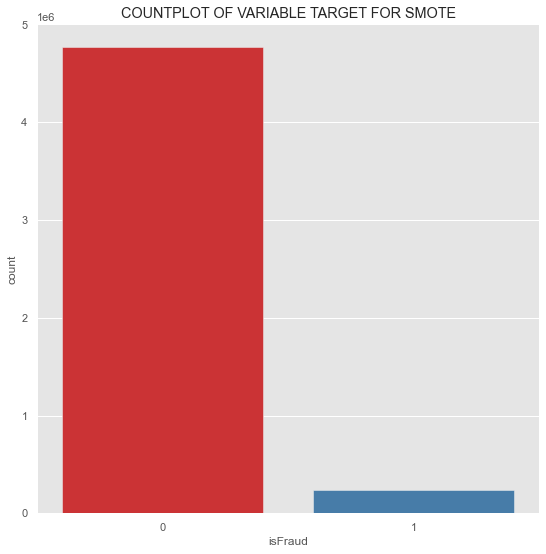

<IPython.core.display.Javascript object>

In [72]:
sns.countplot(x="isFraud", data=y_res, palette="Set1").set(
    title="COUNTPLOT OF VARIABLE TARGET FOR SMOTE"
)

In [73]:
lr = LogisticRegression()
smote_metrics, y_pred_proba = predict(
    lr, X_res, y_res, selected_X_test, y_test, "SMOTE"
)
evaluations = append(evaluations, smote_metrics)
evaluations

C:\Users\User\anaconda3\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,accuracy,precision,recall,f1,name
0,0.998484,0.459798,1.000000,0.629948,class_weight_balanced
0,0.998490,0.460831,1.000000,0.630916,RandomUnderSampling
0,0.998584,0.476777,1.000000,0.645699,RandomOverSampling
0,0.998584,0.476855,0.998539,0.645466,SMOTE
0,0.999237,0.641414,0.927910,0.758511,class_weight_arbitrary
0,0.999271,0.659750,0.898198,0.760726,threshold_0.1
0,0.999573,0.957972,0.699464,0.808559,EditedNearestNeighbours
0,0.999483,0.965935,0.621529,0.756372,benchmark


<IPython.core.display.Javascript object>

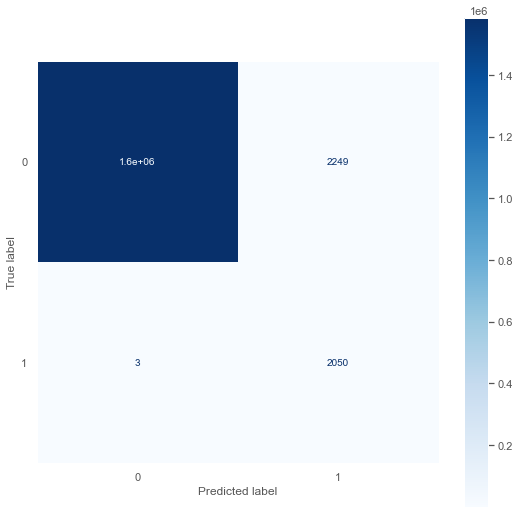

<IPython.core.display.Javascript object>

In [74]:
ConfusionMatrixDisplay.from_predictions(
    y_test, (y_pred_proba >= 0.5).astype(int), cmap="Blues"
)
plt.grid(False)

## ADASYN

ADASYN creates synthetic elements generated from each sample through the density of dots from the majority class in the neighbourhood.

Note: it can create more elements than expected due to some round in the algorithm.

In [75]:
adasyn = ADASYN(random_state=42, sampling_strategy=0.05)
X_res, y_res = adasyn.fit_resample(selected_X_train, y_train)

<IPython.core.display.Javascript object>

[Text(0.5, 1.0, 'COUNTPLOT OF VARIABLE TARGET FOR ADASYN')]

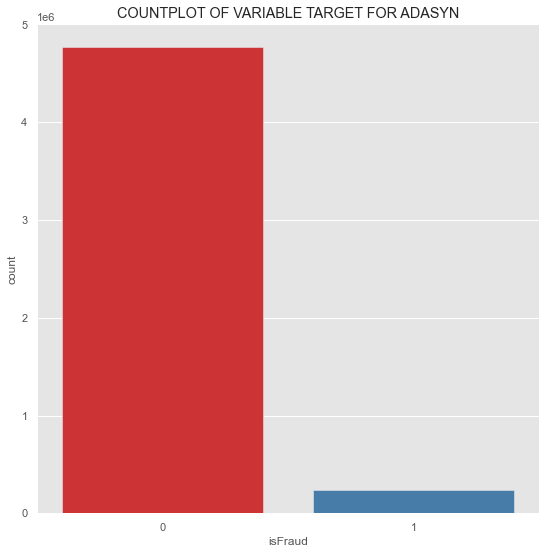

<IPython.core.display.Javascript object>

In [76]:
sns.countplot(x="isFraud", data=y_res, palette="Set1").set(
    title="COUNTPLOT OF VARIABLE TARGET FOR ADASYN"
)

In [77]:
lr = LogisticRegression()
adasyn_metrics, y_pred_proba = predict(
    lr, X_res, y_res, selected_X_test, y_test, "ADASYN"
)
evaluations = append(evaluations, adasyn_metrics)
evaluations

C:\Users\User\anaconda3\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,accuracy,precision,recall,f1,name
0,0.998484,0.459798,1.000000,0.629948,class_weight_balanced
0,0.998490,0.460831,1.000000,0.630916,RandomUnderSampling
0,0.998584,0.476777,1.000000,0.645699,RandomOverSampling
0,0.998612,0.481812,1.000000,0.650301,ADASYN
0,0.998584,0.476855,0.998539,0.645466,SMOTE
0,0.999237,0.641414,0.927910,0.758511,class_weight_arbitrary
0,0.999271,0.659750,0.898198,0.760726,threshold_0.1
0,0.999573,0.957972,0.699464,0.808559,EditedNearestNeighbours
0,0.999483,0.965935,0.621529,0.756372,benchmark


<IPython.core.display.Javascript object>

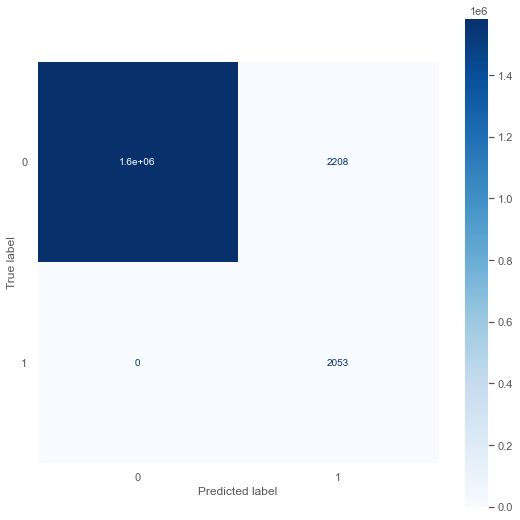

<IPython.core.display.Javascript object>

In [78]:
ConfusionMatrixDisplay.from_predictions(
    y_test, (y_pred_proba >= 0.5).astype(int), cmap="Blues"
)
plt.grid(False)